In [ ]:
# Basic setup
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# name of the folder
!mkdir -p dataset
!mkdir -p plots
# dataset
!kaggle competitions download -c titanic -p dataset
!unzip -q dataset/*.zip -d dataset
!ls dataset

In [ ]:
import os
def my_save_plots(title, xlabel, ylabel, save_name):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not os.path.exists("plots"):
        os.makedirs("plots")
    plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [ ]:
train = pd.read_csv("/content/dataset/train.csv")
test = pd.read_csv("/content/dataset/test.csv")

if 'Survived' not in test:
  test["Survived"] = 0


# **CLEANING OF DATA**

In [ ]:
# To manage the code easily
def preprocess(train, test):
  df = pd.concat([train, test], sort=True).reset_index(drop=True)
  df.drop(columns = ["Ticket", "Name"], axis = 1, inplace = True)
  df.Fare.fillna(df["Fare"].mean(), inplace = True)
  df.Embarked.fillna(df["Embarked"].mode(), inplace = True)
  df.Age.fillna(df.Age.mean(), inplace = True)
  df.Cabin.fillna("X0", inplace=True)

  # better to separate the cabin letter and cabin number for one hot encoding
  # Added parentheses to create capturing groups for regex
  df['Cabin_letter'] = df['Cabin'].str.extract(r'([A-Za-z]+)')
  df['Cabin_number'] = df['Cabin'].str.extract(r'(\d+)')
  df['Cabin_number'] = pd.to_numeric(df['Cabin_number'], errors = 'coerce')
  df['Cabin_number'].fillna(0, inplace=True)     # TODO: was still giving 6 null values
  df.drop(columns = "Cabin", axis = 1,inplace = True)

  # one hot encoding:
  df = pd.get_dummies(df, columns = ["Cabin_letter"], prefix = "Cabin", dtype=int)
  df = pd.get_dummies(df, columns = ["Embarked"], prefix = "Embarked", dtype=int)
  df = pd.get_dummies(df, columns = ["Sex"], prefix = "Sex", dtype=int)

  # dummy encoding
  df.drop(columns=["Embarked_X", "Cabin_X"], axis = 1, inplace = True, errors = "ignore")

  # lets try feature_engineering:
  df['Pclass_bin_fare'] = df["Fare"] // df["Pclass"]
  # df['Pcalss_bin_sex'] = df["Pclass"] - df["Sex_female"]

  df_train = df[: len(train)]
  df_test = df[len(df_train):]

  df_test.drop('Survived', axis = 1, inplace=True)

  return df_train, df_test

In [ ]:
df_train, df_test = preprocess(train, test)

# new_df = preprocess(train, test)
# print(new_df.shape)
# new_df.isnull().sum()

<ipython-input-283-7ce0910a83ea>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Fare.fillna(df["Fare"].mean(), inplace = True)
<ipython-input-283-7ce0910a83ea>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [ ]:
# SOME BASIC PREPROCESSING TASKS:

# print(new_df['Age'].skew()*100)    # for median and mean skewness is same ie. 45.5 % -> can use anything.
# new_df.Survived.value_counts() / len(new_df) * 100   #-> ~74% people survived and 26% died

# categorical = new_df.select_dtypes(include='object').columns.tolist()
# numerical = new_df.select_dtypes(include='number').columns.tolist()
# print("CAT:" , categorical , "\nNUM:" , numerical)

In [ ]:
X = df_train.drop('Survived', axis = 1)
y = df_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 37)
y_train = np.reshape(y_train, (-1, 1))

#### Now lets remove some more noise to make it more better model

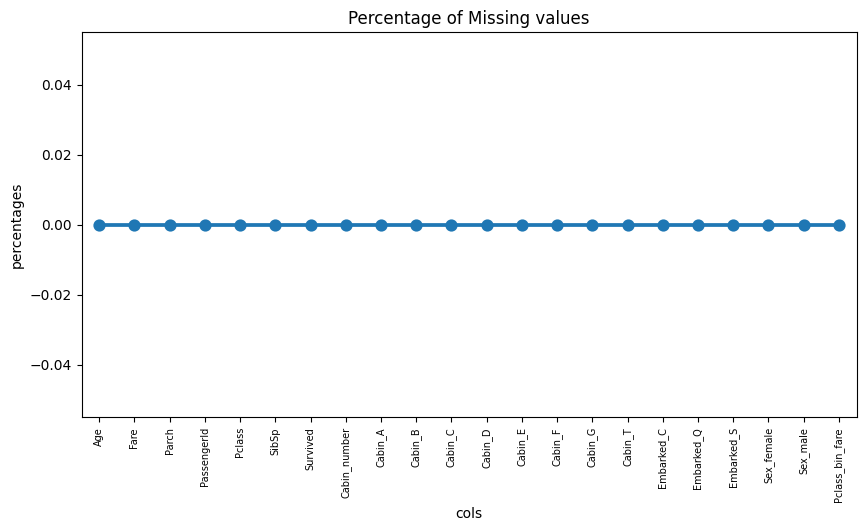

In [ ]:
#outlier detection

missing = pd.DataFrame((df_train.isnull().sum())*100/df_train.shape[0]).reset_index()
plt.figure(figsize=(10,5))
ax = sns.pointplot(x = 'index',y = 0,data=missing)
plt.xticks(rotation =90,fontsize =7)
my_save_plots("Percentage of Missing values", "cols", "percentages", "missing_values")
plt.show()    # -> No outliers. Great

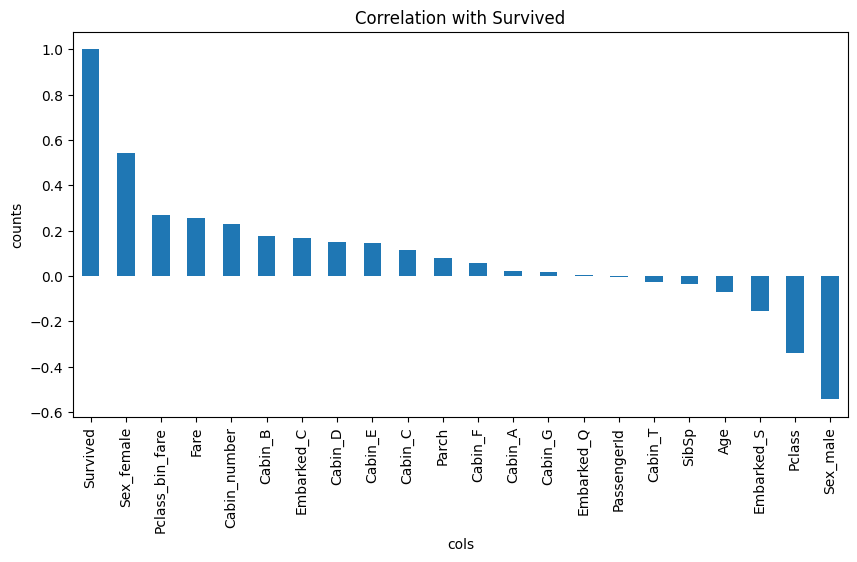

In [ ]:

plt.figure(figsize=(10,5))
df_train.corr()['Survived'].sort_values(ascending=False).plot(kind='bar')
my_save_plots("Correlation with Survived","cols", "counts",  "correlation_survived_barplot")
plt.show()

- females are more likely to survive
- survivors have made paid more fare
- if cabin_number is more above the deck has more chances of survival

In [ ]:
THRESHOLD = 0.2 # 0.5 will only imply that only females are likely to survive

In [ ]:
t = df_train.corr()['Survived']
high_corr_features = t[t > THRESHOLD].sort_values(ascending=False)
print(high_corr_features)

Survived           1.000000
Sex_female         0.543351
Pclass_bin_fare    0.267823
Fare               0.257307
Cabin_number       0.229756
Name: Survived, dtype: float64


In [ ]:
model1 = LogisticRegression(random_state = 37)
model1.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=37)

In [ ]:
# y_pred1 = model1.predict(X_cv)
# print(accuracy_score(y_cv, y_pred1)*100)     # 84.269

In [ ]:
#  model2 =  RandomForestClassifier(random_state = 37)
# model2.fit(X_train, y_train)

In [ ]:
# y_pred2 = model2.predict(X_cv)
# print(accuracy_score(y_cv, y_pred2)*100)

In [ ]:
# model3 = XGBClassifier(enable_categorical = True, random_state = 37)
# model3.fit(X_train, y_train)

In [ ]:
# y_pred3 = model3.predict(X_cv)
# print(accuracy_score(y_cv, y_pred3)*100)      # 83.71%

#### Lets now try with the final predictions with each model

In [ ]:
y_final_pred_1 = model1.fit(X, y).predict(df_test)
y_final_pred_2 = model2.fit(X, y).predict(df_test)
y_final_pred_3 = model3.fit(X, y).predict(df_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# prediction on test set for each model
y_final_pred_1 = model1.predict(X_test)
y_final_pred_2 = model2.predict(X_test)
y_final_pred_3 = model3.predict(X_test)

# accuracy score for each model on the test set
print(accuracy_score(y_test, y_final_pred_1)*100)
print(accuracy_score(y_test, y_final_pred_2)*100)
print(accuracy_score(y_test, y_final_pred_3)*100)

79.3296089385475
100.0
100.0


## model 2 test set predictions so lets consider it

In [ ]:
pred = model3.predict(df_test)
final = pd.DataFrame()
final["PassengerId"] = df_test["PassengerId"]
final["Survived"] = pred
final.to_csv("submission.csv", index = False)